# Ellipse calculations

## Imports

In [1]:
# Python standard library
import sys
import csv


# Scientific computing
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy.ndimage
import scipy.interpolate
#import seaborn as sns


# Program specific
sys.path.append('/home/prestonh/Desktop/Research/pore_stats/pore_stats/rp/')
sys.path.append('/home/prestonh/Desktop/Research/pore_stats/pore_stats/oi/')
import resistive_pulse as rp
import rp_file
import optical_imaging as oi
import oi_file


# Jupyter
from IPython.display import HTML

## Constants

In [2]:
save_data = True
save_plot = True

nm = 10**(-9.)
um = 10**(-6.)

## Load video and events

In [3]:
date = '10-10-2017/'
particle = '293-T_0/'
channel = '10-20-10_1/'
file_index = '0/'

base_path = '/home/prestonh/Desktop/Research/cancer_cells/data/'

oi_vid_file_path = base_path + date + particle + channel + 'oi/bin/test_camera_' + file_index.replace('/','')
oi_events_file_path = base_path + date + particle + channel + 'oi/events/test_camera_' + file_index.replace('/','') + '_events.json'


res_x = 384
res_y = 112
fps = 250000.
exposure_time = .5*10**(-6.)

In [4]:
# Load video
oi_vid = oi_file.Video(oi_vid_file_path, res_x, res_y, fps)

# Load events
oi_events = oi_file.open_event_file_json(oi_events_file_path)

/home/prestonh/Desktop/Research/pore_stats/pore_stats/oi/optical_imaging.py:75: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if pixels != None:


## Output

In [12]:
save_base_path = '/home/prestonh/Desktop/Research/cancer_cells/analysis/data/' + date + particle + channel + file_index

print save_base_path

/home/prestonh/Desktop/Research/cancer_cells/analysis/data/10-10-2017/293-T_0/10-20-10_1/0/


# Create stage

[ 0.03035038  0.99953932]


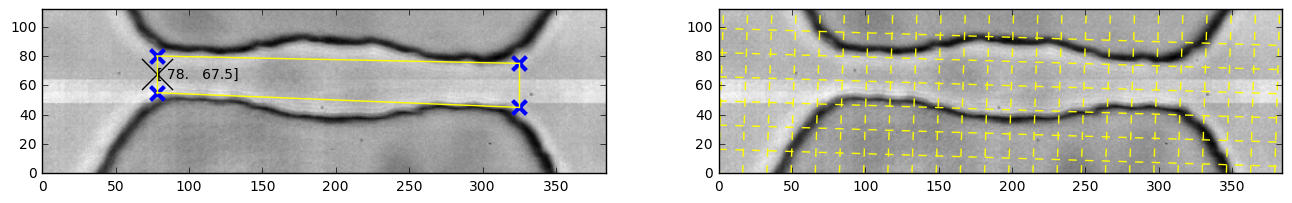

In [7]:
reload(oi)
template_index = 90
template_frame = oi_vid.get_frame(template_index)
c0 = [78, 80]
c1 = [78, 55]
c2 = [325, 45] 
c3 = [325, 75]


oi_stage = oi.Stage(template_frame, c0, c1, c2, c3)
oi_stage.plot_stage()

## Load ellipses

In [8]:
oi_ellipse_base_path = '../data/'
oi_ellipse_path = oi_ellipse_base_path + date + particle + channel + file_index + 'ellipses'

ellipsess = []


with open(oi_ellipse_path, 'r') as file_handle:
    file_reader = csv.reader(file_handle, delimiter = '\t')
    
    # Skip header
    header_length = 2
    for i in range(header_length):
        next(file_reader)
        
        
    for row in file_reader:
        
        if row[0] == 'event #':
            # New event
            ellipsess.append([])
            continue
            
        else:
            ellipse = []
            for ele in row:
                try:
                    ellipse.append(float(ele))
                except:
                    ellipse.append(0)
                    
            ellipsess[-1].append(ellipse)

## Filter

In [9]:
# Load keep indices
filter_file_path = '../data/' + date + particle + channel + file_index + 'filter'

with open(filter_file_path, 'r') as filter_file_handle:
    filter_file_reader = csv.reader(filter_file_handle, delimiter = '\t')
    for row in filter_file_reader:
        if row[0] == 'events':
            keep_indices = [int(ele) for ele in row[1:]]

print 'loaded keep indices (', len(keep_indices), 'events total):\n', keep_indices
filtered_oi_events = [oi_events[i] for i in range(len(oi_events)) if i in keep_indices]
filtered_ellipsess = [ellipsess[i] for i in range(len(ellipsess)) if i in keep_indices]

loaded keep indices ( 190 events total):
[2, 18, 23, 24, 36, 43, 44, 52, 53, 58, 59, 62, 63, 78, 84, 86, 91, 96, 102, 113, 122, 130, 138, 143, 151, 156, 160, 164, 167, 170, 182, 184, 187, 189, 194, 196, 200, 210, 215, 216, 219, 221, 231, 240, 241, 248, 250, 251, 259, 261, 267, 269, 270, 282, 283, 285, 286, 298, 299, 310, 313, 324, 328, 346, 369, 370, 373, 382, 399, 414, 419, 422, 438, 445, 450, 456, 484, 492, 495, 507, 511, 519, 526, 532, 540, 546, 547, 556, 559, 576, 577, 581, 586, 591, 597, 598, 600, 610, 618, 622, 639, 648, 649, 650, 652, 657, 681, 691, 697, 707, 711, 714, 732, 735, 743, 749, 755, 762, 786, 787, 790, 797, 804, 807, 809, 810, 818, 820, 845, 862, 878, 879, 895, 901, 902, 906, 915, 919, 924, 925, 928, 933, 938, 941, 942, 953, 960, 969, 970, 977, 983, 985, 989, 995, 999, 1009, 1013, 1020, 1033, 1034, 1035, 1042, 1059, 1073, 1074, 1086, 1103, 1107, 1114, 1115, 1134, 1143, 1147, 1149, 1153, 1168, 1169, 1179, 1188, 1192, 1204, 1207, 1209, 1215, 1216, 1219, 1233, 1237, 1238

##### Manually remove

In [10]:
manual_remove_indices = []
oi_events = [filtered_oi_events[i] for i in range(len(filtered_oi_events)) if i not in manual_remove_indices]
ellipsess = [filtered_ellipsess[i] for i in range(len(filtered_ellipsess)) if i not in manual_remove_indices]

print 'Manually filtered', len(manual_remove_indices), 'events'

Manually filtered 0 events


## Calculations

In [13]:
features = ['event_num', 'ellipse_num', 'tf', 'x_pix', 'xc_pix', 'xc_um', 'y_pix', 'yc_pix', 'yc_um', 'a_pix', 'a_um', 'b_pix', 'b_um', 'r_pix', 'r_um', 'aspect-ratio', 'theta_rad', 'speed_pix/frame', 'speed_m/s']
output_file_path = save_base_path + 'calculations'

with open(output_file_path, 'w') as output_file_handle:
    output_writer = csv.writer(output_file_handle, delimiter = ',')

    output_writer.writerow(features)

    
    for i, oi_event in enumerate(oi_events):

        event_num = i

        ellipses = ellipsess[i]
        for j, ellipse in enumerate(ellipses):
            ellipse_num = j

            detection_num = int(ellipse[0])

            tf = oi_events[event_num]._detections[detection_num]._tf

            x_pix = ellipse[1]
            y_pix = ellipse[2]
            xc_pix, yc_pix = oi_stage.get_channel_coordinates(x_pix, y_pix)
            xc_um = oi_stage.pixels_to_meters(xc_pix)
            yc_um = oi_stage.pixels_to_meters(yc_pix)

            a_pix = ellipse[3]
            b_pix = ellipse[4]
            a_um = oi_stage.pixels_to_meters(a_pix)
            b_um = oi_stage.pixels_to_meters(b_pix)
            r_pix = np.sqrt(a_pix*b_pix)
            r_um = np.sqrt(a_um*b_um)

            aspect_ratio = a_pix/b_pix

            theta_rad = ellipse[5]


            speed_pixperframe = 0
            speed_mpers = 0
            if (j != 0) and (j != (len(ellipsess[i]) - 1)):
                ellipse_prev = ellipses[j-1]
                ellipse_next = ellipses[j+1]

                x_prev_pix = ellipse_prev[1]
                y_prev_pix = ellipse_prev[2]

                x_next_pix = ellipse_next[1]
                y_next_pix = ellipse_next[2]

                detection_num_prev = int(ellipse_prev[0])
                detection_num_next = int(ellipse_next[0])

                tf_prev = oi_events[event_num]._detections[detection_num_prev]._tf
                tf_next = oi_events[event_num]._detections[detection_num_next]._tf

                speed_pixperframe = (((x_next_pix - x_pix)**2. + (y_next_pix - y_pix)**2.)**.5 + \
                ((x_prev_pix - x_pix)**2. + (y_prev_pix - y_pix)**2.)**.5)/2.

                speed_mpers = oi_stage.pixels_to_meters(speed_pixperframe)
                speed_mpers = speed_mpers * fps


            features = [event_num, ellipse_num, tf, x_pix, xc_pix, xc_um, y_pix, yc_pix, yc_um, a_pix, a_um,\
                        b_pix, b_um, r_pix, r_um, aspect_ratio, theta_rad, speed_pixperframe, speed_mpers]


            output_writer.writerow(features)


In [14]:
def save_list(lst, feature_name, note = None):
    # Open file for writing
    with open(save_base_path + feature_name, 'w') as file_handle:
        
        # Create writer
        file_writer = csv.writer(file_handle, delimiter = '\t')
        
        if note:
            file_writer.writerow([note])
        
        # Loop over list of lists
        for ele in lst:
            file_writer.writerow([ele])
            
def save_lists(lists, feature_names, note = None):
    # Open file for writing
    with open(save_base_path + feature_names[0], 'w') as file_handle:
        
        # Create writer
        file_writer = csv.writer(file_handle, delimiter = '\t')
        
        if note:
            file_writer.writerow([note])
        
        # Loop over list of lists
        for i in range(len(lists[0])):
            file_writer.writerow([lists[0][i], lists[1][i]])

def save_list_of_lists(list_of_lists_1, list_of_lists_2, feature_name, note = None):
    
    # Open file for writing
    with open(save_base_path + feature_name, 'w') as file_handle:
        
        # Create writer
        file_writer = csv.writer(file_handle, delimiter = '\t')
        
        if note:
            file_writer.writerow([note])
        
        # Loop over list of lists
        for i in range(len(list_of_lists_1)):

            list_1 = list_of_lists_1[i]
            list_2 = list_of_lists_2[i]

            # Indicate new event line
            file_writer.writerow(['event #', i])
            
            # Loop over list
            for j in range(len(list_1)):
                file_writer.writerow([list_1[j], list_2[j]])
                    

### Aspect ratio

/home/prestonh/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:67: RuntimeWarning: invalid value encountered in divide


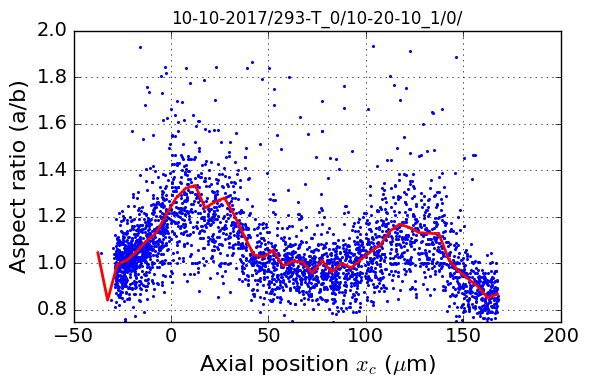

In [15]:
feature_name = 'aspects'
note = 'aspect (a/b) versus channel position (microns)'

xcss = []
aspectss = []

# Loop over events
for i, oi_event in enumerate(oi_events):
    ellipses = ellipsess[i]
    
    ts = []
    xcs = []
    aspects = []
    
    
    # Loop over ellipses within event
    for j, ellipse in enumerate(ellipses):
        tf = oi_event._detections[int(ellipse[0])]._tf
        
        # Get ellipse position
        x = ellipse[1]
        y = ellipse[2]
        
        # Convert to channel units
        xc, yc = oi_stage.get_channel_coordinates(x, y)
        
        # Convert to microns
        xc = oi_stage.pixels_to_meters(xc)
        
        # Get ellipse axes
        L_a = ellipse[3]
        L_b = ellipse[4]
        
        # Convert to microns
        L_a = oi_stage.pixels_to_meters(L_a)
        L_b = oi_stage.pixels_to_meters(L_b)
     
        # Append to list
        xcs.append(xc)
        aspects.append(L_a/L_b)
        
        

    # Append list to list of lists
    xcss.append(xcs)
    aspectss.append(aspects)
    

# Get average information
bin_width = 5
x0 = -55
x1 = 250
counts = np.array([0. for i in range(int(1.*((x1-x0)/bin_width))+1)])
averages = np.array([0. for i in range(int(1.*((x1-x0)/bin_width))+1)])
for i, xcs in enumerate(xcss):
    for j, xc in enumerate(xcs):
        index = int(1.*(xc-x0)/bin_width)
        aspect = aspectss[i][j]
        if (not np.isnan(aspect)) and (aspect != 0) and (not np.isinf(aspect)):
            counts[index] += 1
            averages[index] += 1.*aspect
            

            
            
positions = [x0 + bin_width*(i+.5) for i in range(len(averages))]
averages = [np.divide(1.*averages[i], counts[i]) for i in range(len(averages))]



    
    
# Plot event
for i in range(len(xcss)):
    plt.scatter(xcss[i], aspectss[i], marker = '.', lw = 0)    

# Plot averages
plt.plot(positions, averages, color = 'red', lw = 2)
    

# Range
plt.ylim(0.75, 2)
    
# Cosmetics
plt.title(date + particle + channel + file_index)

plt.xlabel(r'Axial position $x_{c}$ ($\mu$m)', size = 16)
plt.ylabel(r'Aspect ratio (a/b)', size = 16)

plt.tick_params(labelsize = 14)

plt.grid()

plt.tight_layout()




# Save plot
if save_plot:
    plt.savefig(save_base_path + feature_name + '_plot.png', dpi = 100, )

plt.show()



# Save data
if save_data:
    save_list_of_lists(xcss, aspectss, feature_name, note)

## Velocity

In [ ]:
feature_name = 'velocity'
note = 'velocity (m/s) versus channel position (microns)'

tss = []
xcss = []
xc_velocitiess = []

# Loop over events
for i, oi_event in enumerate(oi_events):
    ellipses = ellipsess[i]
    
    
    
    ts = []
    xcs = []
    xc_velocities = []
    
    # Loop over ellipses within event
    for j, ellipse in enumerate(ellipses):
        tf = oi_event._detections[int(ellipse[0])]._tf
        t = 1.*tf/fps
        
        # Get ellipse position
        x = ellipse[1]
        y = ellipse[2]
        
        # Convert to channel units
        xc, yc = oi_stage.get_channel_coordinates(x, y)
        
        # Convert to microns
        xc = oi_stage.pixels_to_meters(xc)
        
        # Calculate velocity
        if j > 0:
            xc_velocity = (xc - xcs[-1])/(t-ts[-1])*10**(-6.)
        else:
            xc_velocity = 0

                
        
        # Append to list
        ts.append(t)
        xcs.append(xc)
        xc_velocities.append(xc_velocity)
    
        
        
    # Append list to list of lists
    tss.append(ts)
    xcss.append(xcs)
    xc_velocitiess.append(xc_velocities)
        
    # Plot event
    plt.plot(xcs, xc_velocities)
    
    
plt.ylim(0,5)
    
# Cosmetics
plt.title(date + particle + channel + file_index)


plt.xlabel(r'Axial position $x_{c}$ ($\mu m$)', size = 16)
plt.ylabel(r'Velocity (m/s)', size = 16)

plt.tick_params(labelsize = 14)

plt.grid()
    
plt.tight_layout()

# Save plot
if save_plot:
    plt.savefig(save_base_path + feature_name + '_plot.png', dpi = 100, )

plt.show()


# Save data
if save_data:
    save_list_of_lists(xcss, xc_velocitiess, feature_name, note)

## Blur

In [ ]:
feature_name = 'blur'
note = 'Calculated blur at each position based on velocity and exposure rate (all in microns)'

tss = []
xcss = []
xc_velocitiess = []
blurss = []

# Loop over events
for i, oi_event in enumerate(oi_events):
    ellipses = ellipsess[i]
    
    
    # Create empty lists to store event data
    ts = []
    xcs = []
    xc_velocities = []
    blurs = []
    
    # Loop over ellipses within event
    for j, ellipse in enumerate(ellipses):
        tf = oi_event._detections[int(ellipse[0])]._tf
        t = 1.*tf/fps
        
        # Get ellipse position
        x = ellipse[1]
        y = ellipse[2]
        
        # Convert to channel units
        xc, yc = oi_stage.get_channel_coordinates(x, y)
        
        # Convert to microns
        xc = oi_stage.pixels_to_meters(xc)
        
        # Calculate velocity
        if j > 0:
            xc_velocity = (xc - xcs[-1])/(t-ts[-1])*10**(-6.)
        else:
            xc_velocity = 0
            
        # Calculate blur
        blur = xc_velocity * exposure_time * 10**(6.)

                
        
        # Append to list
        ts.append(t)
        xcs.append(xc)
        xc_velocities.append(xc_velocity)
        blurs.append(blur)
    
        
        
    # Append list to list of lists
    tss.append(ts)
    xcss.append(xcs)
    xc_velocitiess.append(xc_velocities)
    blurss.append(blurs)
        
    # Plot event
    plt.plot(xcs, blurs)
    
    
    
plt.ylim(0,2.5)
    
# Cosmetics
plt.title(date + particle + channel + file_index)


plt.xlabel(r'Axial position $x_{c}$ ($\mu$m)', size = 16)
plt.ylabel(r'Blur distance ($\mu$m)', size = 16)

plt.tick_params(labelsize = 14)

plt.grid()

plt.tight_layout()

# Save plot
if save_plot:
    plt.savefig(save_base_path + feature_name + '_plot.png', dpi = 100, )

plt.show()


# Save data
if save_data:
    save_list_of_lists(xcss, xc_velocitiess, feature_name, note)

## Particle radius

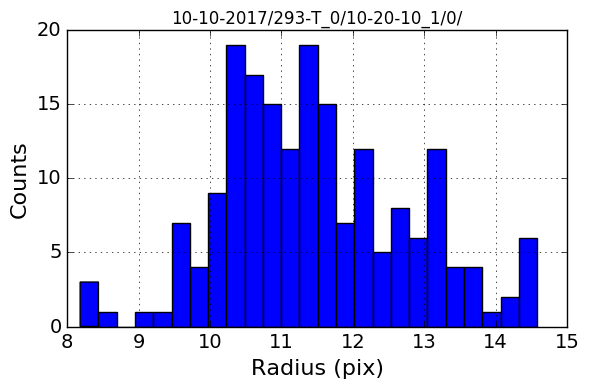

In [16]:
feature_name = 'radius'
note = 'Calculated radius of each particle based off of frame when particle is outside channel'

radii_pix = []
radii_um = []

# Loop over events
for i, oi_event in enumerate(oi_events):
    try:
        ellipses = ellipsess[i]


        # Create empty lists to store event data
        xcs = []
        event_radii_pix = []

        # Loop over ellipses within event
        for j, ellipse in enumerate(ellipses):

            # Get ellipse position
            x = ellipse[1]
            y = ellipse[2]

            # Convert to channel units
            xc, yc = oi_stage.get_channel_coordinates(x, y)

            # Convert to microns
            xc = oi_stage.pixels_to_meters(xc)

            # Get ellipse axes lengths
            a = ellipse[3]
            b = ellipse[4]



            # Get average radius
            avg_radius_pix = np.sqrt(a*b)


            # Append to list
            xcs.append(xc)
            event_radii_pix.append(avg_radius_pix)


        # Convert arrays to numpy
        xcs = np.array(xcs)
        event_radii_pix = np.array(event_radii_pix)



        # Get index where particle is out of channel
        xc_left = -30
        xc_right = 0
        radius_pix = event_radii_pix[(xcs > xc_left) & (xcs < xc_right)][0]


        # Append to list
        radii_pix.append(radius_pix)
        radii_um.append(oi_stage.pixels_to_meters(radius_pix))
        
    except:
        print 'failed on', i
   
radii_pix = np.array(radii_pix)
radii_pix[np.isnan(radii_pix)] = 0

radii_um = np.array(radii_um)
radii_um[np.isnan(radii_um)] = 0

        
# Plot event
plt.hist(radii_pix, bins = 25)
    
# Cosmetics
plt.title(date + particle + channel + file_index)


plt.xlabel(r'Radius (pix)', size = 16)
plt.ylabel(r'Counts', size = 16)

plt.tick_params(labelsize = 14)

plt.grid()

plt.tight_layout()

# Save plot
if save_plot:
    plt.savefig(save_base_path + feature_name + '_plot.png', dpi = 100, )

plt.show()




# Save data
if save_data:
    save_lists([radii_pix, radii_um], ['radii_pix', 'radii_um'], note)

## Velocity vs Radius

In [ ]:
x_feature_name = 'radius'
y_feature_name = 'velocity'

note = 'Calculated radius of each particle based off of frame when particle is outside channel\n' + \
'Calculated maximum velocity while in channel'

xcss = []
radii = []
xc_velocities = []

# Loop over events
for i, oi_event in enumerate(oi_events):
    ellipses = ellipsess[i]
    
    
    # Create empty lists to store event data
    ts = []
    xcs = []
    event_radii = []
    event_xc_velocities = []
    
    
    
    
    
    # Loop over ellipses within event
    for j, ellipse in enumerate(ellipses):
        
        # Get ellipse time
        tf = oi_event._detections[int(ellipse[0])]._tf
        t = 1.*tf/fps
        
        # Get ellipse position
        x = ellipse[1]
        y = ellipse[2]
        
        # Convert to channel units
        xc, yc = oi_stage.get_channel_coordinates(x, y)
        
        # Convert to microns
        xc = oi_stage.pixels_to_meters(xc)
        
        # Get ellipse axes lengths
        a = ellipse[3]
        b = ellipse[4]
        
        
        # Get average radius
        avg_radius = np.sqrt(a*b)
        
        
        # Convert average radius to micron
        avg_radius = oi_stage.pixels_to_meters(avg_radius)
        
        # Calculate velocity
        if j > 0:
            xc_velocity = (xc - xcs[-1])/(t-ts[-1])*10**(-6.)
        else:
            xc_velocity = 0
    

        # Append to list
        ts.append(t)
        xcs.append(xc)
        event_radii.append(avg_radius)
        event_xc_velocities.append(xc_velocity)  

    # Convert arrays to numpy
    xcs = np.array(xcs)
    event_radii = np.array(event_radii)
    event_xc_velocities = np.array(event_xc_velocities)

    
    # Get index where particle is out of channel
    xc_left = -30
    xc_right = -10
    radius = None
    if len(event_radii[(xcs >= xc_left) & (xcs <= xc_right)]) > 0:
        radius = event_radii[(xcs >= xc_left) & (xcs <= xc_right)][0]
    
    
    
    # Get max velocity inside channel
    xc_left = 0
    xc_right = 150
    xc_velocity = None
    if len(event_xc_velocities[(xcs >= xc_left) & (xcs <= xc_right)]) > 0:
        xc_velocity = np.max(event_xc_velocities[(xcs >= xc_left) & (xcs <= xc_right)])
    
    
    # Append to list
    if radius and xc_velocity:
        radii.append(radius)
        xc_velocities.append(xc_velocity)
        
        
        
    
# Convert to numpy array
radii = np.array(radii)
xc_velocities = np.array(xc_velocities)

radii[np.isnan(radii)] = 0
xc_velocities[np.isnan(xc_velocities)] = 0




# Get averages
avg_radii = []
avg_xc_velocities = []
for i in range((int(np.max(radii))-int(np.min(radii)))*2+1+1):
    
    # Calculate radius interval for average
    radius = int(np.min(radii))+.5*(i+1)
    avg_radii.append(radius)
    
    # Calculate averages
    avg_xc_velocity = np.mean(xc_velocities[(radii >= radius - 0.25) & (radii < radius + 0.25)])

    
    
    # Append to lists
    avg_xc_velocities.append(avg_xc_velocity)


        

# Plot radii vs velocities
plt.scatter(radii, xc_velocities, marker = 's', lw = 3, color = 'red', alpha = 0.5)


# Plot averages
plt.plot(avg_radii, avg_xc_velocities, color = 'k', ls = '--', lw = 3)


plt.xlim(5,11)
plt.ylim(2,4)
    
# Cosmetics
plt.title(date + particle + channel + file_index)


plt.xlabel(r'Radius ($\mu$m)', size = 16)
plt.ylabel(r'Velocities (m/s)', size = 16)

plt.tick_params(labelsize = 14)

plt.grid()


plt.tight_layout()

# Save plot
if save_plot:
    plt.savefig(save_base_path + x_feature_name + '_' + y_feature_name + '_plot.png', dpi = 100, )

plt.show()


# Save data
if save_data:
    pass
    #save_list(radii, feature_name, note)

## Radius vs Aspect

In [ ]:
x_feature_name = 'radius'
y_feature_name = 'aspect'

note = 'Calculated radius of each particle based off of frame when particle is outside channel'

radii = []
aspect_outsides = []
aspect_narrows = []
aspect_cavities = []

# Loop over events
for i, oi_event in enumerate(oi_events):
    ellipses = ellipsess[i]
    
    
    # Create empty lists to store event data
    xcs = []
    event_radii = []
    event_aspects = []
    
    # Loop over ellipses within event
    for j, ellipse in enumerate(ellipses):
        
        # Get ellipse position
        x = ellipse[1]
        y = ellipse[2]
        
        # Convert to channel units
        xc, yc = oi_stage.get_channel_coordinates(x, y)
        
        # Convert to microns
        xc = oi_stage.pixels_to_meters(xc)
        
        # Get ellipse axes lengths
        a = ellipse[3]
        b = ellipse[4]
        
        
        # Get average radius
        avg_radius = np.sqrt(a*b)
        
        
        # Convert average radius to micron
        avg_radius = oi_stage.pixels_to_meters(avg_radius)
    

        # Append to list
        xcs.append(xc)
        event_radii.append(avg_radius)
        event_aspects.append(np.divide(a, b))
        

    # Convert arrays to numpy
    xcs = np.array(xcs)
    event_radii = np.array(event_radii)
    event_aspects = np.array(event_aspects)
    

    
    # Get index where particle is out of channel
    xc_left = -30
    xc_right = -10
    radius = None
    if len(event_radii[(xcs >= xc_left) & (xcs <= xc_right)]) > 0:
        radius = event_radii[(xcs >= xc_left) & (xcs <= xc_right)][0]
    
    # Get index where particle is outside channel
    xc_left = -100
    xc_right = -10
    
    aspect_outside = None
    if len(event_aspects[(xcs >= xc_left) & (xcs <= xc_right)]) > 0:
        aspect_outside = event_aspects[(xcs >= xc_left) & (xcs <= xc_right)][0]
    
    # Get index where particle is in narrow entrance
    xc_left = 0
    xc_right = 50
    
    aspect_narrow = None
    if len(event_aspects[(xcs >= xc_left) & (xcs <= xc_right)]) > 0:
        aspect_narrow = event_aspects[(xcs >= xc_left) & (xcs <= xc_right)][0]
        
    # Get index where particle is in central cavity
    xc_left = 50
    xc_right = 100
    
    aspect_cavity = None
    if len(event_aspects[(xcs >= xc_left) & (xcs <= xc_right)]) > 0:
        aspect_cavity = event_aspects[(xcs >= xc_left) & (xcs <= xc_right)][0]
    
    
    # Append to list
    if radius and aspect_outside and aspect_narrow and aspect_cavity:
        radii.append(radius)
        aspect_outsides.append(aspect_outside)
        aspect_narrows.append(aspect_narrow)
        aspect_cavities.append(aspect_cavity)
    
# Convert to numpy array
radii = np.array(radii)
aspect_outsides = np.array(aspect_outsides)
aspect_narrows = np.array(aspect_narrows)
aspect_cavities = np.array(aspect_cavities)

radii[np.isnan(radii)] = 0
aspect_outsides[np.isnan(aspect_outsides)] = 0
aspect_narrows[np.isnan(aspect_narrows)] = 0
aspect_cavities[np.isnan(aspect_cavities)] = 0



# Get averages
avg_radii = []
avg_aspect_outsides = []
avg_aspect_narrows = []
avg_aspect_cavities = []
for i in range((int(np.max(radii))-int(np.min(radii)))*2+1+1):
    
    # Calculate radius interval for average
    radius = int(np.min(radii))+.5*(i+1)
    avg_radii.append(radius)
    
    # Calculate averages
    avg_aspect_outside = np.mean(aspect_outsides[(radii >= radius - 0.25) & (radii < radius + 0.25)])
    avg_aspect_narrow= np.mean(aspect_narrows[(radii >= radius - 0.25) & (radii < radius + 0.25)])
    avg_aspect_cavity = np.mean(aspect_cavities[(radii >= radius - 0.25) & (radii < radius + 0.25)])
    
    
    # Append to lists
    avg_aspect_outsides.append(avg_aspect_outside)
    avg_aspect_narrows.append(avg_aspect_narrow)
    avg_aspect_cavities.append(avg_aspect_cavity)


        
# Plot event
plt.plot([0,100],[1,1], lw = 0.5, c = 'k')

#plt.scatter(radii, aspect_outsides, marker = 's', lw = 3, color = 'green', alpha = 0.25, label = 'outside')
plt.scatter(radii, aspect_narrows, marker = 'o', lw = 0, color = 'red', label = 'narrow', alpha = 0.5)
plt.scatter(radii, aspect_cavities, marker = 'x', label = 'cavity', alpha = 0.5)

# Plot averages
#plt.plot(avg_radii, avg_aspect_outsides, color = 'green', ls = '--', lw = 3)
plt.plot(avg_radii, avg_aspect_narrows, color = 'red', ls = '--', lw = 3)
plt.plot(avg_radii, avg_aspect_cavities, color = 'blue', ls = '--', lw = 3)

plt.xlim(5,9)
plt.ylim(0.8,1.4)
    
# Cosmetics
plt.title(date + particle + channel + file_index)


plt.xlabel(r'Radius ($\mu$m)', size = 16)
plt.ylabel(r'Aspects ($a/b$)', size = 16)

plt.tick_params(labelsize = 14)

plt.grid()

plt.legend(loc = 'best')

plt.tight_layout()

# Save plot
if save_plot:
    plt.savefig(save_base_path + x_feature_name + '_' + y_feature_name + '_plot.png', dpi = 100, )

plt.show()


# Save data
if save_data:
    save_list(radii, feature_name, note)

## Get ellipse images

In [ ]:
def plot_ellipse(ellipse):
    
    x_center = ellipse[1]
    y_center = ellipse[2]
    a = ellipse[3]
    b = ellipse[4]
    theta = ellipse[5]
    
    
    # Plot ellipse perimiter
    xs = []
    ys = []
    for i in range(100):
        angle = i*2*np.pi/99.
        x_ellipse = a*np.cos(angle)
        y_ellipse = b*np.sin(angle)
        x = x_center + np.cos(theta)*x_ellipse + np.sin(theta)*y_ellipse
        y = y_center + np.sin(theta)*x_ellipse - np.cos(theta)*y_ellipse
        
        xs.append(x)
        ys.append(y)
        
    plt.plot(xs, ys, lw = .5, ls = ':', c = 'white')
    
    
    # Plot ellipse axes
    plt.plot([x_center, x_center + a], [y_center, y_center], lw = .5, c = 'white')
    plt.plot([x_center, x_center], [y_center, y_center + b], lw = .5, c = 'white')
    
    
    # Plot ellipse text
    yoffset = 5
    a_um = oi_stage.pixels_to_meters(a)
    b_um = oi_stage.pixels_to_meters(b)
    
    
    
    plt.text(x_center + 30, y_center + 30 - 4*yoffset,'a = ' + str(round(a_um, 2)) + r' $\mu$m', ha = 'right', va = 'bottom', color = 'white', fontweight = 'bold')    
    plt.text(x_center + 30, y_center + 30 - 3*yoffset,'b = ' + str(round(b_um, 2)) + r' $\mu$m', ha = 'right', va = 'bottom', color = 'white', fontweight = 'bold')    
    plt.text(x_center + 30, y_center + 30 - 2*yoffset,'a/b = ' + str(round(a/b, 2)), ha = 'right', va = 'bottom', color = 'white', fontweight = 'bold')    
    plt.text(x_center + 30, y_center + 30 - 1*yoffset,r'$\theta$ = ' + str(round(theta, 2)), ha = 'right', va = 'bottom', color = 'white', fontweight = 'bold')    
    


In [ ]:
x_feature_name = 'radius'
y_feature_name = 'aspect'

note = 'Calculated radius of each particle based off of frame when particle is outside channel'



# Loop over events
for i, oi_event in enumerate(oi_events):
    print i
    
    try:
        ellipses = ellipsess[i]


        # Create empty lists to store event data
        xcs = []
        detection_indices = []


        # Loop over ellipses within event
        for j, ellipse in enumerate(ellipses):

            # Get ellipse position
            x = ellipse[1]
            y = ellipse[2]

            # Convert to channel units
            xc, yc = oi_stage.get_channel_coordinates(x, y)

            # Convert to microns
            xc = oi_stage.pixels_to_meters(xc)

            #
            detection_index = ellipse[0]


            # Append to list
            xcs.append(xc)
            detection_indices.append(int(ellipse[0]))


        # Convert arrays to numpy
        xcs = np.array(xcs)
        detection_indices = np.array(detection_indices)
        ellipses = np.array(ellipses)



        # Get index where particle is out of channel
        xc_left = -100
        xc_right = -10
        detection_index = detection_indices[(xcs >= xc_left) & (xcs <= xc_right)][0]
        frame_outside = oi_vid.get_frame(oi_event._detections[detection_index]._tf)

        ellipse_outside = ellipses[(xcs >= xc_left) & (xcs <= xc_right)][0]


        # Get index where particle is inside narrow constriction
        xc_left = 10
        xc_right = 40
        detection_index = detection_indices[(xcs >= xc_left) & (xcs <= xc_right)][0]
        frame_narrow = oi_vid.get_frame(oi_event._detections[detection_index]._tf)
        ellipse_narrow = ellipses[(xcs >= xc_left) & (xcs <= xc_right)][0]

        # Get index where particle is inside cavity
        xc_left = 45
        xc_right = 100
        detection_index = detection_indices[(xcs >= xc_left) & (xcs <= xc_right)][0]
        frame_cavity = oi_vid.get_frame(oi_event._detections[detection_index]._tf)
        ellipse_cavity = ellipses[(xcs >= xc_left) & (xcs <= xc_right)][0]


        # Create figure


        fig, axes = plt.subplots(1,3, figsize = (12,3))

        plt.suptitle('event # ' + str(i) + '/' + str(len(oi_events)))

        # outside
        x_center = ellipse_outside[1]
        y_center = ellipse_outside[2]

        plt.sca(axes[0])
        plt.imshow(frame_outside, cmap = 'gray', origin = 'lower')
        plot_ellipse(ellipse_outside)
        plt.xlim(x_center-30, x_center + 30)
        plt.ylim(y_center - 30, y_center + 30)


        plt.xlabel('outside')

        plt.xticks([])
        plt.yticks([])




        # narrow
        x_center = ellipse_narrow[1]
        y_center = ellipse_narrow[2]

        plt.sca(axes[1])
        plt.imshow(frame_narrow, cmap = 'gray', origin = 'lower')
        plot_ellipse(ellipse_narrow)
        plt.xlim(x_center-30, x_center + 30)
        plt.ylim(y_center - 30, y_center + 30)


        plt.xlabel('narrow')


        plt.xticks([])
        plt.yticks([])

        # cavity
        x_center = ellipse_cavity[1]
        y_center = ellipse_cavity[2]

        plt.sca(axes[2])
        plt.imshow(frame_cavity, cmap = 'gray', origin = 'lower')
        plot_ellipse(ellipse_cavity)
        plt.xlim(x_center-30, x_center + 30)
        plt.ylim(y_center - 30, y_center + 30)

        
        plt.xlabel('cavity')
        plt.xticks([])
        plt.yticks([])

   

        if save_plot:
            plt.savefig(save_base_path + 'ellipse_fits/' + str(i) + '.png', dpi = 100)

        plt.close()
        plt.show()
        
    except:
        print '\tfailed on ', i
    
d


In [ ]:
plt.imshow(oi_vid.get_frame(oi_events[0]._detections[int(ellipsess[0][0][0])]._tf), cmap = 'gray', origin = 'lower')
plt.show()

## Trajectories

In [ ]:
for i, oi_event in enumerate(oi_events):
    
    
    
    xcs = []
    ycs = []
    for j, ellipse in enumerate(ellipsess[i]):
        x = ellipse[1]
        y = ellipse[2]
        
        xc, yc = oi_stage.get_channel_coordinates(x, y)
        
        xc = oi_stage.pixels_to_meters(xc)
        yc = oi_stage.pixels_to_meters(yc)
        
        xcs.append(xc)
        ycs.append(yc)
        
    
        
    plt.plot(xcs, ycs)
    
    
plt.show()

## Aspect-radius scatter

In [ ]:
base_file_path = '/home/prestonh/Desktop/Research/cancer_cells/analysis/data/'

dates = ['10-10-2017']
particles = ['293-T_0']
channels = ['10-20-10_0']
indices = ['0']

file_paths = [base_file_path + dates[i] + '/' + particles[i] + '/' + channels[i] + '/' + indices[i] + '/calculations/' for i in range(len(dates))]

In [ ]:
print file_paths